# Download of GPS time series
This notebook collects GPS data given a lat-long box

In [2]:
# import modules
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Collect information about the GPS site location

In [25]:
# read csv file
gps_loc = pd.read_csv("gps_locations.csv",usecols=['station','latitude','longitude','elevation'],
    dtype={'latitude': np.float64, 'longitude': np.float64,'elevation':np.float64})
print(gps_loc)

     station   latitude   longitude    elevation
0       AB01  52.209503 -174.204758    25.483989
1       AB02  52.970604 -168.854671   192.803423
2       AB04  63.656863 -170.567443   136.547210
3       AB06  54.885321 -163.423455   500.432692
4       AB07  55.349275 -160.476760    89.571502
...      ...        ...         ...          ...
1805    WWAY -81.577000  -28.402700  1195.388000
1806    YBRA  45.122100 -109.267400  2072.518000
1807    YESX  28.378336 -108.919639  1506.487003
1808    YMER  77.432895  -24.326329  1070.068249
1809    YUMX  32.027692 -115.199203   -30.200000

[1810 rows x 4 columns]


In [26]:
# Pick a station
stalist = "AB01"
# index of the station chosen
ista=gps_loc[gps_loc["station"]==stalist].index.values.astype('int64')[0]

In [42]:
# OR select within a lat long box
latmin = 35.
latmax = 36.
longmin = -120.
longmax = -119.
ik=gps_loc[ (gps_loc["latitude"]>=latmin )& (gps_loc["latitude"]<latmax ) & (gps_loc["longitude"]>=longmin )& (gps_loc["longitude"]<longmax )].index.values.astype('int64')
# 

In [43]:
stalist = gps_loc["station"].iloc[ik].values.tolist()
print(stalist)
print(len(stalist))
print(stalist[0])

['BVPP', 'P522', 'P537', 'P543', 'P544', 'P545', 'P547', 'P563', 'P564', 'P565', 'P809', 'P810']
12
BVPP


## download data
Build URLs and download from the FTP server.

In [ ]:
# initialize nested lists
df=[]
for ista,sta in enumerate(stalist):
    dfsta=[]
    print("Downloading and processing " + sta )
    
    
    # what's the lat long el
    iista=gps_loc[gps_loc["station"]==sta].index.values.astype('int64')[0]
    lat=gps_loc["latitude"].iloc[iista]
    lon=gps_loc["longitude"].iloc[iista]
    el=gps_loc["elevation"].iloc[iista]
    
    
    file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
    r = requests.get(file_url).text.splitlines()  # download, read text, split lines into a list
    ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[]
    for iday in r:  # this loops through the days of data
        crap=iday.split()
        if len(crap)<10:continue
        date.append((crap[1]))
        date_year.append(float(crap[2]))
        ue.append(float(crap[6])*1000)
        un.append(float(crap[7])*1000)
        uv.append(float(crap[8])*1000)
#     #             # errors
#         se.append(float(crap[10])*1000)
#         sn.append(float(crap[11])*1000)
#         sv.append(float(crap[12])*1000)

          # make dataframe
        crap={'station':sta,'latitude':lat,'longitude':lon,'elevation':el,'date':date,'date_year':date_year,'east':ue,'north':un,'up':uv}
        if len(df)==0:
            df = pd.DataFrame(crap, columns = ['station', 'latitude', 'longitude','elevation', 'date','date_year','east','north','up'])
        else:
            df=pd.concat([df,pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])])
        if len(dfsta)==0:
            dfsta = pd.DataFrame(crap, columns = ['station', 'latitude', 'longitude','elevation', 'date','date_year','east','north','up'])
        else:
            dfstadf=pd.concat([dfsta,pd.DataFrame(crap, columns = ['station', 'latitude', 'longitude','elevation','date','date_year','east','north','up'])])

    print("writing to disk"  + "gps_"+sta+".csv")   
    dfsta.to_csv("gps_"+sta+".csv")



writing to diskgps_BVPP.csv
writing to diskgps_P522.csv


In [ ]:
# plot time series
fig,ax=plt.subplots(3,1,figsize=(11,8),sharex=True)
for ista,sta in enumerate(stalist):
    ax[0].plot(df['date_year'][df['station']==sta],df['east'][df['station']==sta]);ax[0].grid(True);ax[0].set_ylabel('East (mm)')
    ax[1].plot(df['date_year'][df['station']==sta],df['north'][df['station']==sta]);ax[1].grid(True);ax[1].set_ylabel('North (mm)')
    ax[2].plot(df['date_year'][df['station']==sta],df['up'][df['station']==sta]);ax[2].grid(True);ax[2].set_ylabel('Up (mm)')
    ax[2].set_xlabel('Time (years)')

(32.0, 39.0)

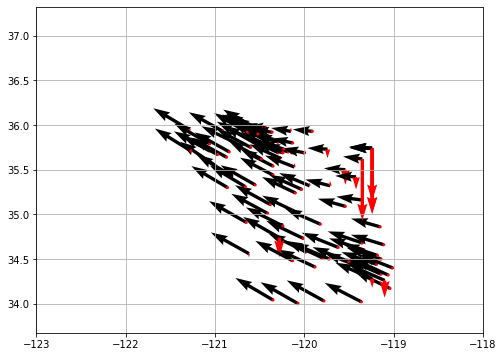

In [ ]:
# make a map with the vectors
fig0=plt.figure(figsize=(8,6))
for ista,sta in enumerate(stalist):
    plt.quiver(gps_loc['longitude'][gps_loc['station']==sta],gps_loc['latitude'][gps_loc['station']==sta],Ve[ista]/100,Vn[ista]/100,scale=1,units='xy')
    plt.quiver(gps_loc['longitude'][gps_loc['station']==sta],gps_loc['latitude'][gps_loc['station']==sta],0,Vu[ista]/50,scale=1,color='r',units='xy')
plt.grid(True)
plt.axis('equal')
plt.xlim(-123,-118)
plt.ylim(32,39)

In [ ]:
# Next activities could be fitting a sinisoidal functions
